# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass

In [ ]:
import pickle
import random
import warnings
from pathlib import Path

import numpy as np
from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
import torch
import torchvision
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from matplotlib import colors, pyplot as plt


%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [3]:
SEED = 1937

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
# работаем на видеокарте
DEVICE = torch.device("cuda")
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset/testset')
# масштаб изображений
RESCALE_SIZE = 224

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

Датасет для работы с данными

In [5]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, transforms, rescale_size=224):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        
        self.rescale_size = rescale_size
        self.transforms = transforms

        available_modes = ['train', 'val', 'test']
        if self.mode not in available_modes:
            print(f"{self.mode} is not correct; correct modes: {available_modes}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        x = self.load_sample(self.files[index])
        x = self.transforms(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((self.rescale_size, self.rescale_size))
        return np.array(image)

Создаем датасеты

In [6]:
from sklearn.model_selection import train_test_split


train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))


train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

Примеры картинок и лэйблов

Давайте посмотрим на наших героев внутри датасета.

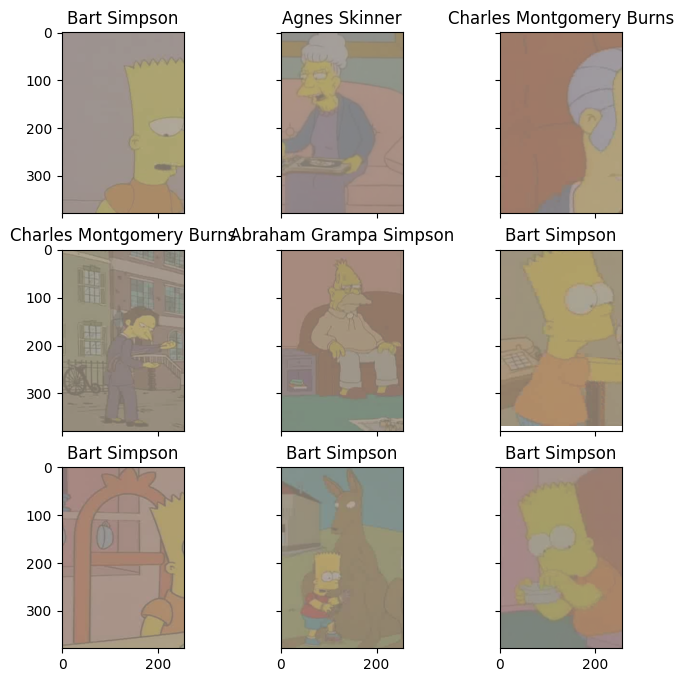

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)
    

val_dataset = SimpsonsDataset(val_files, mode='val', transforms=transforms.Compose([transforms.ToTensor(),]))
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


Создание модели

За основу возьмем предобученную ResNet34

In [8]:
from torchvision.models import resnet34, ResNet34_Weights

weights = ResNet34_Weights.DEFAULT
model = resnet34(weights=weights)
print(model)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 240MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
n_classes = len(np.unique(train_val_labels))
model.fc = torch.nn.Linear(512, n_classes)

In [10]:
for parameter in model.parameters():
    parameter.requires_grad = False
    
layers_to_unfreeze = ['fc', 'avgpool', 'layer4']
for layer_to_unfreeze in layers_to_unfreeze:
    layer = getattr(model, layer_to_unfreeze)
    for parameter in layer.parameters():
        parameter.requires_grad = True

Запустим обучение сети.

In [11]:
from sklearn.metrics import f1_score


def calculate_f1_score(labels: torch.Tensor, preds: torch.Tensor) -> float:
    labels = labels.cpu().numpy()
    preds = preds.cpu().numpy()
    return f1_score(labels, preds, average='micro')
    
    

def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_f1_score = 0
    batch_count = 0
  
    pbar = tqdm(train_loader)
    for inputs, labels in pbar:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item()
        running_f1_score += calculate_f1_score(preds, labels)
        batch_count += 1
              
    train_loss = running_loss / batch_count
    train_f1_score = running_f1_score / batch_count
    return train_loss, train_f1_score


def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_f1_score = 0
    batch_count = 0
    
    pbar = tqdm(val_loader)
    for inputs, labels in pbar:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item()
        running_f1_score += calculate_f1_score(preds, labels)
        batch_count += 1
    val_loss = running_loss / batch_count
    vall_f1_score = running_f1_score / batch_count
    return val_loss, vall_f1_score


def save_model(model):
    torch.save(model.state_dict(), 'best.pth')


epochs = 20

model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.1)

preprocess = weights.transforms()
train_dataset = SimpsonsDataset(train_files, mode='train', transforms=preprocess)
val_dataset = SimpsonsDataset(val_files, mode='val', transforms=preprocess)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128)

best_f1_score = 0
train_history = []
val_history = []
for epoch in range(1, epochs + 1):
    print('Epoch {}:'.format(epoch))
    train_loss, train_f1 = fit_epoch(model, train_dataloader, loss_function, optimizer)
    train_history.append((train_loss, train_f1))
    print('Train. Loss: {}, F1-score: {}'.format(train_loss, train_f1))
    with torch.no_grad():
        val_loss, val_f1 = eval_epoch(model, val_dataloader, loss_function)
    print('Validation. Loss: {}, F1-score: {}'.format(val_loss, val_f1))
    val_history.append((val_loss, val_f1))
    
    if val_f1 > best_f1_score:
        print('Is best result. Save model.')
        save_model(model)
        
    scheduler.step()

Epoch 1:


100%|██████████| 123/123 [02:43<00:00,  1.33s/it]


Train. Loss: 1.1307215724534136, F1-score: 0.7532018317171123


100%|██████████| 41/41 [00:51<00:00,  1.26s/it]


Validation. Loss: 0.4894096907682535, F1-score: 0.8947167843388961
Is best result. Save model.
Epoch 2:


100%|██████████| 123/123 [01:37<00:00,  1.26it/s]


Train. Loss: 0.25572784142038685, F1-score: 0.9447699333921049


100%|██████████| 41/41 [00:30<00:00,  1.32it/s]


Validation. Loss: 0.30182110627249975, F1-score: 0.9312486628155755
Is best result. Save model.
Epoch 3:


100%|██████████| 123/123 [01:37<00:00,  1.26it/s]


Train. Loss: 0.08171993843847658, F1-score: 0.9891677992457635


100%|██████████| 41/41 [00:31<00:00,  1.31it/s]


Validation. Loss: 0.24158037290340517, F1-score: 0.9443931857081729
Is best result. Save model.
Epoch 4:


100%|██████████| 123/123 [01:38<00:00,  1.24it/s]


Train. Loss: 0.02841105475658324, F1-score: 0.9973323170731707


100%|██████████| 41/41 [00:31<00:00,  1.29it/s]


Validation. Loss: 0.2143757461411197, F1-score: 0.9464658215661105
Is best result. Save model.
Epoch 5:


100%|██████████| 123/123 [01:38<00:00,  1.25it/s]


Train. Loss: 0.01353463309824588, F1-score: 0.9989837398373984


100%|██████████| 41/41 [00:32<00:00,  1.28it/s]


Validation. Loss: 0.20493069745418502, F1-score: 0.9485852588789047
Is best result. Save model.
Epoch 6:


100%|██████████| 123/123 [01:37<00:00,  1.26it/s]


Train. Loss: 0.007991093939654833, F1-score: 0.9994918699186992


100%|██████████| 41/41 [00:32<00:00,  1.27it/s]


Validation. Loss: 0.20218928226428787, F1-score: 0.9487992083868207
Is best result. Save model.
Epoch 7:


100%|██████████| 123/123 [01:37<00:00,  1.26it/s]


Train. Loss: 0.005149642105888181, F1-score: 0.9997459349593496


100%|██████████| 41/41 [00:31<00:00,  1.30it/s]


Validation. Loss: 0.2001161725691906, F1-score: 0.9492037066752247
Is best result. Save model.
Epoch 8:


100%|██████████| 123/123 [01:37<00:00,  1.26it/s]


Train. Loss: 0.003672860895010938, F1-score: 0.9997459349593496


100%|██████████| 41/41 [00:31<00:00,  1.30it/s]


Validation. Loss: 0.1981266765151082, F1-score: 0.9510857937526744
Is best result. Save model.
Epoch 9:


100%|██████████| 123/123 [01:38<00:00,  1.25it/s]


Train. Loss: 0.0029741939388185255, F1-score: 0.9997459349593496


100%|██████████| 41/41 [00:31<00:00,  1.31it/s]


Validation. Loss: 0.19685653192786182, F1-score: 0.9512763425331622
Is best result. Save model.
Epoch 10:


100%|██████████| 123/123 [01:38<00:00,  1.25it/s]


Train. Loss: 0.002274366216809769, F1-score: 0.9998094512195121


100%|██████████| 41/41 [00:31<00:00,  1.30it/s]


Validation. Loss: 0.19501172178765622, F1-score: 0.9514434905862217
Is best result. Save model.
Epoch 11:


100%|██████████| 123/123 [01:38<00:00,  1.25it/s]


Train. Loss: 0.0019219989809813357, F1-score: 0.9998729674796748


100%|██████████| 41/41 [00:31<00:00,  1.29it/s]


Validation. Loss: 0.19560687039501784, F1-score: 0.9520619383825417
Is best result. Save model.
Epoch 12:


100%|██████████| 123/123 [01:38<00:00,  1.25it/s]


Train. Loss: 0.0018454458057214089, F1-score: 0.9998729674796748


100%|██████████| 41/41 [00:32<00:00,  1.27it/s]


Validation. Loss: 0.19454043894642736, F1-score: 0.9516574400941378
Is best result. Save model.
Epoch 13:


100%|██████████| 123/123 [01:39<00:00,  1.23it/s]


Train. Loss: 0.0017684229168798624, F1-score: 0.9999364837398373


100%|██████████| 41/41 [00:31<00:00,  1.29it/s]


Validation. Loss: 0.19533484356432426, F1-score: 0.9516574400941378
Is best result. Save model.
Epoch 14:


100%|██████████| 123/123 [01:38<00:00,  1.25it/s]


Train. Loss: 0.0018118184151665528, F1-score: 0.9998729674796748


100%|██████████| 41/41 [00:31<00:00,  1.29it/s]


Validation. Loss: 0.19586266636303284, F1-score: 0.9508718442447582
Is best result. Save model.
Epoch 15:


100%|██████████| 123/123 [01:39<00:00,  1.24it/s]


Train. Loss: 0.0017527497526848826, F1-score: 0.9998729674796748


100%|██████████| 41/41 [00:31<00:00,  1.29it/s]


Validation. Loss: 0.1966128281158645, F1-score: 0.9499191003423193
Is best result. Save model.
Epoch 16:


100%|██████████| 123/123 [01:39<00:00,  1.24it/s]


Train. Loss: 0.0016913180380522053, F1-score: 0.9998729674796748


100%|██████████| 41/41 [00:31<00:00,  1.32it/s]


Validation. Loss: 0.19586334341182943, F1-score: 0.9510623930252461
Is best result. Save model.
Epoch 17:


100%|██████████| 123/123 [01:39<00:00,  1.24it/s]


Train. Loss: 0.0016608072967245811, F1-score: 0.9999364837398373


100%|██████████| 41/41 [00:31<00:00,  1.29it/s]


Validation. Loss: 0.19555265797165836, F1-score: 0.9518245881471973
Is best result. Save model.
Epoch 18:


100%|██████████| 123/123 [01:40<00:00,  1.23it/s]


Train. Loss: 0.0016478444577376471, F1-score: 0.9999364837398373


100%|██████████| 41/41 [00:31<00:00,  1.31it/s]


Validation. Loss: 0.19668702458644785, F1-score: 0.9499425010697475
Is best result. Save model.
Epoch 19:


100%|██████████| 123/123 [01:38<00:00,  1.25it/s]


Train. Loss: 0.0016026045489162812, F1-score: 0.9998729674796748


100%|██████████| 41/41 [00:31<00:00,  1.28it/s]


Validation. Loss: 0.19675651756001683, F1-score: 0.9514434905862217
Is best result. Save model.
Epoch 20:


100%|██████████| 123/123 [01:38<00:00,  1.25it/s]


Train. Loss: 0.0015765047491134365, F1-score: 0.9998729674796748


100%|██████████| 41/41 [00:31<00:00,  1.31it/s]

Validation. Loss: 0.19674356590683867, F1-score: 0.950109649122807
Is best result. Save model.


Построим кривые обучения


График функции потерь

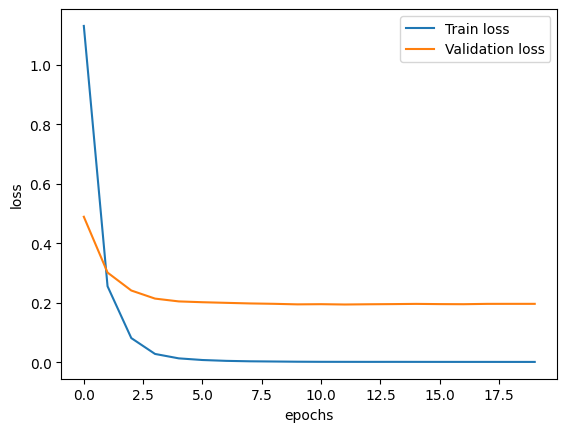

In [12]:
train_loss = [_[0] for _ in train_history]
val_loss = [_[0] for _ in val_history]
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

График F1-score

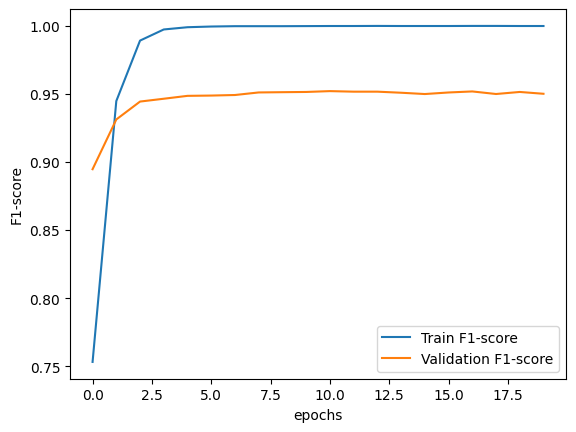

In [13]:
train_f1 = [_[1] for _ in train_history]
val_f1 = [_[1] for _ in val_history]
plt.plot(train_f1, label='Train F1-score')
plt.plot(val_f1, label='Validation F1-score')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('F1-score')
plt.show()

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [15]:
import pandas as pd


def load_best_weights(model):
    model.load_state_dict(torch.load('best.pth'))
    

def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs


def create_submission(preds, files):
    submit = pd.DataFrame(columns=['Id'])
    submit['Id'] = files
    submit['Expected'] = preds
    submit.to_csv('submission.csv', index=False)

    
load_best_weights(model)
model.eval()

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
test_dataset = SimpsonsDataset(test_files, mode='test', transforms=preprocess)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

create_submission(preds, test_filenames)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


![image](https://github.com/VeraKasianenko/VeraKasianenko/assets/112972833/156d054f-1812-4846-ad55-21542c56a9cb)
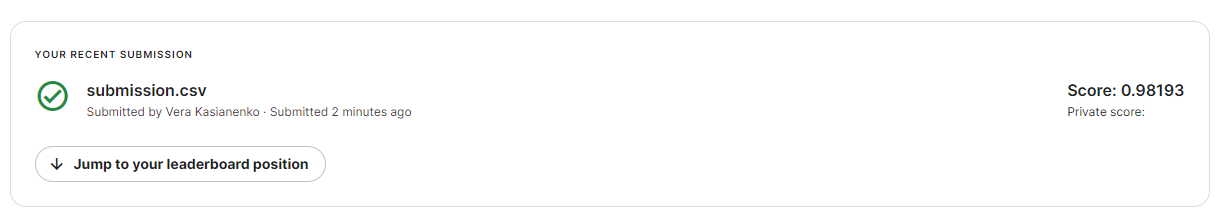

Ник на kaggle: verakasianenko 
Score: 0.98193